In [1]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools

from IPython.display import HTML
def show_df(df):
    return HTML(df.to_html(notebook=True))

In [2]:
moonshot_file = "../../covid_submissions_all_info.csv"
df = pd.read_csv(moonshot_file)
PandasTools.AddMoleculeColumnToFrame(df,'SMILES','Molecule')

/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3,6,7,9,10,11,12,13,14,15,18,19,27,28,29,30,31,32,33,34,35,36,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,66,67,69,70,71,72,73,74,75,76,84,85,86,87,89,90,91,92,93,94,95,96,104,105,106,107,109,110,111,112,113,114,115,116,124,125,126,127,129,130,131,132,133,134,135,136,144,145,146,147,149,150,151,152,153,154,155,156,164,165,166,167,169,170,171,172,173,174,175,176,184,185,186,187,189,190,191,192,193,194,195,196,204,205,206,207,209,210,211,212,213,214,215,216,224,225,226,227,229,230,231,232,233,234,235,236,244,245,246,247,249,253,254,255,256,257,258,259,275,276) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
[12:45:49] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:45:49] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:45

In [3]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdchem

def GetTrueScaffold(mol,generic=False):
    #Not sure if hybridisation of dummy atom is correct
    #Not sure on properties
    #Seems to work as desired
    """
    Takes RDKit mol object
    Returns mol object of the murcko scaffold with original algorithm
    Stereochemistry is lost
    """
    mol = MurckoScaffold.GetScaffoldForMol(mol)
    atom_to_remove = []
    atom_to_clean = []
    
    for a in mol.GetAtoms():
        #Remove chirality
        mol.GetAtomWithIdx(a.GetIdx()).SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
        
        #For atoms bonded to only one other atom, these must be removed
        if len(a.GetBonds()) == 1:
            #Get index of atom to delete and append to deletion list
            atom_to_remove.append(a.GetIdx())

    #If there are atoms to delte
    if len(atom_to_remove) > 0:
        #Create an editable molecule (now RW)
        emol = rdchem.RWMol(mol)
        #Every time an atom is delted the index changes
        #Deletion list must be reversed to avoid rogue deletions
        for a in atom_to_remove[::-1]:
            #Remove atom by index a
            emol.RemoveAtom(a)
    #If the molecule is already the correct murcko scaffold set emol = mol
    else:
        emol = mol
    
    #This line used to cause errors
    #SanitizeMol(emol) often failed due to aromaticity
    #Attempts to solve this included replacing previously bonded atoms with the
    #wild card *
    #It seems clearing aromatic flags solved the issue
    try:
        #Clearing aromatic flags seems to fix everything
        Chem.Kekulize(emol,clearAromaticFlags=True)
        Chem.SanitizeMol(emol)
    except:
        #Error
        #Will show the input molecule and attempted editted molecule (before sanitization attempt)
        display("Input Mol")
        display(mol)
        display("Output Emol")
        display(emol)
        raise ("Error in santisation of new molecule")
        return False
    
    #The above procedure will remove all remaining decorating groups on scaffold
    #In some cases (like sulfonyl) this will leave an aliphatic chain
    #Additional application of MurckoScaffold algorithm is needed
    #However the RDKit implementation is sufficient 
    emol = MurckoScaffold.GetScaffoldForMol(emol)
    
    #If the generic scaffold is desired (Flag), make generic
    if generic:
        emol = MurckoScaffold.MakeScaffoldGeneric(emol)

    #Return the molecule
    return emol

In [4]:
def MolFromName(name):
    """
    Function to find molecule in dataframe by CID
    input: (string) CID
    output: (object) mol
    """
    reference_row = df[df["CID"] == name]
    if len(reference_row) == 1:
        return Chem.MolFromSmiles(reference_row.iloc[0]["SMILES"])
    else:
        print("Name not found in df")
        return False

In [5]:
#activity_df = df[["CID","r_avg_IC50","r_curve_IC50","f_avg_IC50","f_curve_IC50"]]
activity_df = df[["CID","f_avg_IC50"]].dropna()

In [6]:
#activity_df = activity_df.dropna(how="all",subset=["r_avg_IC50","r_curve_IC50","f_avg_IC50","f_curve_IC50"])

In [7]:
def CleanCol(value):
    if isinstance(value, str):
        value = value.strip("]").strip("[")
        try:
            return float(value)
        except:
            print("ERROR:", value)
            return "NaN"
    elif isinstance(value, float):
        return value
    else:
        return "NaN"
    

In [8]:
#activity_df["r_curve_IC50"] = activity_df.apply(lambda x: CleanCol(x.r_curve_IC50), axis = 1)

In [9]:
"""
Select all rows that appear in previously identified lists of interest
Sort by lowest IC50
"""

'\nSelect all rows that appear in previously identified lists of interest\nSort by lowest IC50\n'

In [10]:
activity_df[["CID","f_avg_IC50"]]

AttributeError: module 'pandas.io.formats.format' has no attribute '_get_adjustment'

                       CID  f_avg_IC50
24      DAR-DIA-23aa0b97-8   54.272964
27     DAR-DIA-23aa0b97-11   63.554925
35     DAR-DIA-23aa0b97-19   26.719515
36     DAR-DIA-23aa0b97-20   57.590417
107     WAR-XCH-eb7b662f-2   99.010000
...                    ...         ...
20809   LUO-POS-e1dab717-1    0.073219
20810   LUO-POS-e1dab717-2    0.090364
20818  LUO-POS-e1dab717-10    0.264725
20819  LUO-POS-e1dab717-11    0.275118
20820  LUO-POS-e1dab717-12    0.202767

[2260 rows x 2 columns]

In [11]:
molecule_set = []
with open("largest_scaffold_set_with_dock_single.csv","r") as readfile:
    for line in readfile.readlines():
        molecule_set.append(line.strip())

In [12]:
activity_df[activity_df["CID"].isin(molecule_set)].nsmallest(100, columns="f_avg_IC50")

AttributeError: module 'pandas.io.formats.format' has no attribute '_get_adjustment'

                      CID  f_avg_IC50
607    DAN-LON-a5fc619e-3    0.784006
772    NIR-THE-c331be7a-2    1.172090
2459   PAU-UNI-8cdd41c7-1    1.889434
776    NIR-THE-c331be7a-6    2.004125
3952  MED-COV-4280ac29-37    2.202279
3931  MED-COV-4280ac29-15    2.639505
3220   MIH-UNI-e573136b-5    2.717021
1727   DAR-DIA-fb20be43-7    2.745165
4277   LON-WEI-8f408cad-2    3.287717
4279   LON-WEI-8f408cad-4    3.843760
126    TRY-UNI-714a760b-3    4.222340
1726   DAR-DIA-fb20be43-6    4.606206
3948  MED-COV-4280ac29-33    4.773755
3946  MED-COV-4280ac29-31    5.761793
4280   LON-WEI-8f408cad-5    6.217158
4520  LON-WEI-adc59df6-45    6.474408
3929  MED-COV-4280ac29-13    7.733314
771    NIR-THE-c331be7a-1    9.229303
3115   WAR-XCH-79d12f6e-6   14.216485
142   TRY-UNI-714a760b-19   16.065560
346   DUN-NEW-f8ce3686-24   17.360830
4492  LON-WEI-adc59df6-17   20.161945
129    TRY-UNI-714a760b-6   24.581194
4485  LON-WEI-adc59df6-10   25.468075
141   TRY-UNI-714a760b-18   26.199767
1017   DAV-C

In [27]:
len(docked_ligand_series)

59

In [14]:
docked_ligand_series_and_activity = activity_df[activity_df["CID"].isin(docked_ligand_series)].nsmallest(100, columns="f_avg_IC50")

In [15]:
len(docked_ligand_series_and_activity)

8

In [16]:
mols_to_show = [MolFromName(x) for x in list(docked_ligand_series_and_activity["CID"])]

legends = []
for a,b in zip (list(docked_ligand_series_and_activity["CID"]),list(docked_ligand_series_and_activity["f_avg_IC50"])):
    legends.append(a +"\n\n\n"+str(round(b, 5)))

In [17]:
legends

['DAN-LON-a5fc619e-3\n\n\n0.78401',
 'PAU-UNI-8cdd41c7-1\n\n\n1.88943',
 'MED-COV-4280ac29-37\n\n\n2.20228',
 'MED-COV-4280ac29-15\n\n\n2.6395',
 'MIH-UNI-e573136b-5\n\n\n2.71702',
 'MED-COV-4280ac29-33\n\n\n4.77375',
 'MED-COV-4280ac29-13\n\n\n7.73331',
 'NEH-REV-107bcf72-5\n\n\n37.40706']

In [18]:
from rdkit.Chem import Draw

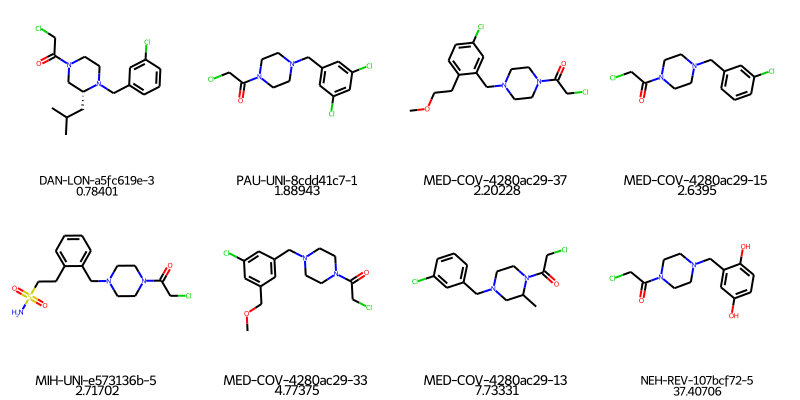

In [19]:
Draw.MolsToGridImage(mols_to_show,molsPerRow=4,legends = legends)

In [20]:
docked_name = []
with open("../../../molecules_with_poses.txt") as file:
    for line in ((file.readlines()[0]).split(", ")):
        docked_name.append(line.strip("'").strip("['").strip("']"))

In [21]:
docked_name

['ANT-OPE-a517596a-1',
 'MUS-SCH-c2f96c06-4',
 'KRI-LIF-2e3dfaa5-1',
 'WAR-XCH-b0339bbe-1',
 'WAR-XCH-b0339bbe-6',
 'WAR-XCH-bdd24732-13',
 'MAK-UNK-0955449e-29',
 'GAB-REV-4a4e2ff3-20',
 'BAR-COM-4e090d3a-1',
 'CHR-SOS-54d5cf3e-3',
 'WAR-XCH-e55cba98-10',
 'AUS-ARG-7cfdce8f-5',
 'MUS-SCH-c2f96c06-2',
 'ALV-UNI-7ff1a6f9-48',
 'WAR-XCH-b0339bbe-2',
 'DUN-NEW-f8ce3686-18',
 'WAR-XCH-72a8c209-2',
 'MIH-UNI-3396182e-10',
 'KIM-UNI-60f168f5-9',
 'CHR-SOS-f7373dd1-1',
 'MUS-SCH-c2f96c06-3',
 'TRY-UNI-714a760b-13',
 'CHR-SOS-b301fc01-5',
 'CHA-KIN-f512e507-1',
 'MAK-UNK-9e4a73aa-9',
 'MAK-UNK-0955449e-3',
 'MED-UNK-28939ac5-3',
 'CHR-SOS-e960e883-1',
 'WAR-XCH-bdd24732-11',
 'RAI-NOV-2f6a9876-3',
 'DAR-DIA-03336633-15',
 'SIM-SYN-a98e6a07-6',
 'WAR-XCH-79d12f6e-14',
 'ADA-UNI-f8e79267-5',
 'MAK-UNK-9e4a73aa-3',
 'SIM-SYN-a98e6a07-5',
 'TRY-UNI-714a760b-14',
 'CHA-KIN-ceadbd93-3',
 'CHA-KIN-f512e507-2',
 'DAR-DIA-43a5904b-13',
 'CHA-KIN-f512e507-3',
 'MUS-SCH-c2f96c06-1',
 'MAK-UNK-9e4a73aa-7'

In [22]:
sub1 = df.loc[df["CID"].isin(docked_name)]

In [23]:
len(sub1)

4551

In [24]:
sub2 = sub1.loc[sub1["CID"].isin(list(activity_df["CID"]))]

In [25]:
len(sub2)

105

In [26]:
print(list(sub2["CID"]))

['DAR-DIA-23aa0b97-8', 'DAR-DIA-23aa0b97-11', 'DAR-DIA-23aa0b97-19', 'DAR-DIA-23aa0b97-20', 'WAR-XCH-eb7b662f-2', 'TRY-UNI-714a760b-3', 'TRY-UNI-714a760b-6', 'TRY-UNI-714a760b-12', 'TRY-UNI-714a760b-18', 'TRY-UNI-714a760b-19', 'TRY-UNI-714a760b-20', 'TRY-UNI-714a760b-22', 'TRY-UNI-714a760b-24', 'JOR-UNI-2fc98d0b-12', 'AGN-NEW-891393a6-1', 'DUN-NEW-f8ce3686-22', 'DUN-NEW-f8ce3686-23', 'DUN-NEW-f8ce3686-24', 'CHR-SOS-7098f804-10', 'CHR-SOS-7098f804-14', 'JOH-MSK-a63bdd1d-4', 'DAN-LON-a5fc619e-3', 'DAN-LON-a5fc619e-8', 'NIR-THE-c331be7a-1', 'NIR-THE-c331be7a-2', 'NIR-THE-c331be7a-6', 'NIR-THE-0d6461ce-8', 'GIA-UNK-a79af1bc-1', 'RUT-UNI-630c5802-20', 'DAV-CRI-3edb475e-4', 'DAV-CRI-3edb475e-6', 'DAV-CRI-14a23e73-1', 'GAB-REV-70cc3ca5-8', 'BAR-COM-4e090d3a-6', 'DAR-DIA-fb20be43-4', 'DAR-DIA-fb20be43-6', 'DAR-DIA-fb20be43-7', 'BRU-LEF-ae0885ba-1', 'GIA-UNK-20b63697-2', 'GIA-UNK-20b63697-6', 'MAK-UNK-af83ef51-2', 'MAK-UNK-af83ef51-6', 'TAM-UNI-d1c3dd9f-5', 'PAU-UNI-8cdd41c7-1', 'PAU-UNI-52c042

In [28]:
#CID, SMILES, docking (bool), f_avg_IC50 (bool), 
#CID, SMILES, has_dock (bool), has_f_avg_IC50 (bool), f_avg_IC50



20997